In [1]:
# Author: Robert Guthrie

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)
torch.use_deterministic_algorithms(True)

In [2]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [3]:

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)
        self.dropout = nn.Dropout(0.5)
        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        lstm_feats = self.dropout(lstm_feats)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                    self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [4]:
import pickle as pkl
training_set = pkl.load(open("train_data_embedded.pkl", "rb"))
validation_set = pkl.load(open("dev_data_embedded.pkl", "rb"))
test_set = pkl.load(open("test_data_embedded.pkl", "rb"))

In [5]:
training_data = []
validation_data = []
test_data = []
for data in training_set:
    training_data.append((torch.tensor(data["embedded_words"],dtype=torch.int), torch.tensor(data["tags"],dtype=torch.int)))
for data in validation_set:
    validation_data.append((torch.tensor(data["embedded_words"],dtype=torch.int), torch.tensor(data["tags"],dtype=torch.int)))
for data in test_set:
    test_data.append((torch.tensor(data["embedded_words"],dtype=torch.int), torch.tensor(data["tags"],dtype=torch.int)))

In [6]:
from torch.utils.data import DataLoader
training_set = DataLoader(training_data, batch_size=32, shuffle=False)
validation_set = DataLoader(validation_data, batch_size=32, shuffle=False)
test_set = DataLoader(test_data, batch_size=32, shuffle=False)

In [9]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM =5
HIDDEN_DIM = 4

word_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

tag_to_ix = {"O": 0, "B": 1, "I": 2, START_TAG: 3, STOP_TAG: 4}

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.001)

def evaluate(model, validation_data):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for sentence, tags in validation_data:
            loss = model.neg_log_likelihood(sentence, tags)
            total_loss += loss.item()
    return total_loss / len(validation_data)

# list_loss_training = []
for epoch in range(50):
    # loss_epoch = 0
    for sentences,tags in training_set:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before eacinstanceh 
        optimizer.zero_grad()
        total_loss = 0
        for sentence,tag in zip(sentences,tags):
            loss = model.neg_log_likelihood(sentence, tag)
            loss = loss
            loss.backward()
            total_loss = total_loss+loss
        # loss = model.neg_log_likelihood(sentences, tags)
        # loss_epoch = loss_epoch + total_loss
        optimizer.step()
        print("Epoch: ", epoch, "   loss:", total_loss)
        total_loss=0
    # list_loss_training.append(loss_epoch/len(training_set))
    # loss_epoch = 0

Epoch:  0    loss: tensor([2288.2148], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([1495.4089], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([1010.8766], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([880.4386], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([570.7507], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([524.2978], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([603.3827], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([503.0515], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([553.6196], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([625.9503], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([475.6017], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([403.7942], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([524.0914], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([563.8794], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([458.6647], grad_fn=<AddBackward0>)
Epoch:  0    loss: tensor([602.3365], grad_fn=<AddBackward0>)
Epoch

In [19]:
len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM

(43050, {'O': 0, 'B': 1, 'I': 2, '<START>': 3, '<STOP>': 4}, 5, 4)

In [10]:
torch.save(model.state_dict(), "model.pt")

In [12]:
load_model = torch.load("model.pt")
model.load_state_dict(load_model)

<All keys matched successfully>

In [8]:
model.save("hell.pt")

AttributeError: 'BiLSTM_CRF' object has no attribute 'save'

In [21]:
ind = 170
print(test_data[ind][1].tolist())
model.load_state_dict(load_model)
with torch.no_grad():
    print(model(test_data[ind][0])[1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
ind = 0
print(test_data[ind][1])
with torch.no_grad():
    print(model(test_data[ind][0])[1])

tensor([0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=torch.int32)
[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
test_data[ind][0]

tensor([  101, 19474,  6956,  1741,  5760,  1111,  1103,  3469,  1104,  3212,
          119,  1109,  2486,  1114, 13117,  1846,  1329,  1107,  1353,  1877,
         1110,   102,     0,     0,     0,     0,     0,     0,     0,     0],
       dtype=torch.int32)

In [15]:
len(test_data[ind][0])

30

In [16]:
import pickle as pkl
pkl.dump(model, open('bi_lstm_crf.pkl', 'wb'))

In [17]:
import pickle as pkl
ml1 = pkl.load(open("bi_lstm_crf.pkl", "rb"))

In [16]:
ind = 175
print(test_data[ind][1].tolist())
with torch.no_grad():
    print(ml1(test_data[ind][0])[1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


NameError: name 'ml1' is not defined

In [12]:
# torch.save(model.state_dict(), 'model_10p.pth')

In [13]:
# torch.save(model, 'full_model_10p.pth')

In [17]:
test_y = []
predicted_y = []
for i in range(len(test_data)):
    test_y.extend(test_data[i][1].tolist())
    predicted_y.extend(model(test_data[ind][0])[1])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204


In [18]:
from sklearn.metrics import classification_report
report = classification_report(test_y, predicted_y)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      5211
           1       0.15      0.02      0.04       456
           2       0.21      0.03      0.06       483

    accuracy                           0.84      6150
   macro avg       0.41      0.35      0.34      6150
weighted avg       0.75      0.84      0.78      6150



In [14]:
from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(test_y, predicted_y)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      5211
           1       0.11      0.10      0.10       456
           2       0.14      0.06      0.08       483

    accuracy                           0.78      6150
   macro avg       0.37      0.36      0.36      6150
weighted avg       0.75      0.78      0.76      6150



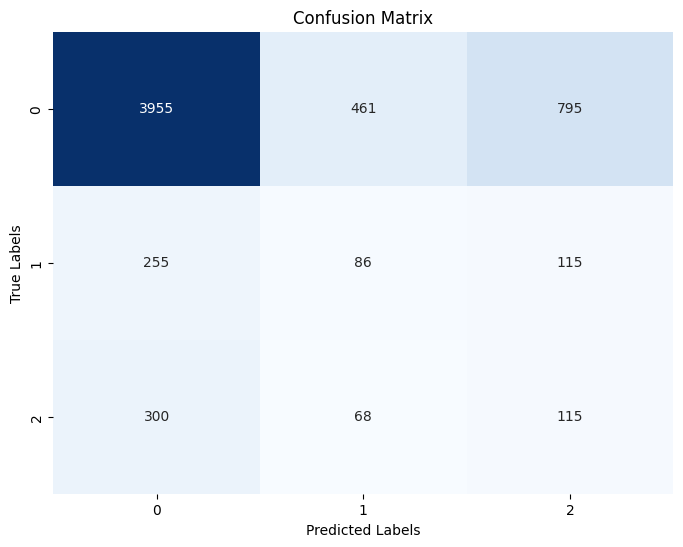

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_y, predicted_y)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(test_y), yticklabels=np.unique(predicted_y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()